# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# 1.**Data Preprocessing**
I am using Colab.
Using the whole data set and doing preprocessing my self
and then i am trying to build the model.

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from collections import Counter

### **1.1 Reading Data**


In [6]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv')
resource_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/resources.csv')

### **1.2 Preprocessing of project_subject_categories**





In [7]:
catogories = list(train_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python
catogories_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    catogories_list.append(temp.strip())
    
train_data['clean_categories'] = catogories_list
train_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### **1.3 Preprocessing of project_subject_subcategories**


In [8]:
sub_catogories = list(train_data['project_subject_subcategories'].values)

sub_catogories_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_catogories_list.append(temp.strip())

train_data['clean_subcategories'] = sub_catogories_list
train_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


### **1.4 Preprocessing of project grade categories**



In [9]:
print(train_data['project_grade_category'].values[0])
print("*"*50)
print(train_data['project_grade_category'].values[150])
print("*"*50)
print(train_data['project_grade_category'].values[1000])
print("*"*50)
print(train_data['project_grade_category'].values[20000])
print("*"*50)


train_data['project_grade_category'].value_counts()

Grades PreK-2
**************************************************
Grades 3-5
**************************************************
Grades 3-5
**************************************************
Grades PreK-2
**************************************************


Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [10]:
preprocessed_project_grade_categories= []

for grade_cat in tqdm(train_data["project_grade_category"]):
   
    grade_cat = grade_cat.replace('-', '_')  #Replacing(-) with(_)
    grade_cat = grade_cat.replace('Grades', '') #Removing grades as it is redundant
   
    grad_cat = ' '.join(f for f in grade_cat.split())
    preprocessed_project_grade_categories.append(grad_cat.strip())

100%|██████████| 109248/109248 [00:00<00:00, 522238.45it/s]


### **1.5 Preprocessing of teacher prefix**


In [11]:
train_data['teacher_prefix'] = train_data['teacher_prefix'].fillna('null')


In [12]:

def replace_cate(lst):          # Removing (.) in Mrs. 
    return lst.replace('.','')
   

train_data['teacher_prefix']= train_data['teacher_prefix'].astype(str).apply(replace_cate)

### **1.6 Adding a new feature Number of words in title**


In [13]:
title_word_count = []


In [14]:
for a in train_data["project_title"] :
    b = len(a.split())
    title_word_count.append(b)

In [15]:
train_data["title_word_count"] = title_word_count


In [16]:
train_data.head(5)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,title_word_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,7
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,5
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,Health_Sports,Health_Wellness TeamSports,7
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs,KY,2016-10-06 21:16:17,Grades PreK-2,Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,Literacy_Language Math_Science,Literacy Mathematics,2
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs,TX,2016-07-11 01:10:09,Grades PreK-2,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,Math_Science,Mathematics,3


### **1.7 Merging 4 essays into single essay**

In [17]:
train_data["essay"] = train_data["project_essay_1"].map(str) +\
                        train_data["project_essay_2"].map(str) + \
                        train_data["project_essay_3"].map(str) + \
                        train_data["project_essay_4"].map(str)

### **1.8 Adding a new feature Number of words in essay**

In [18]:
essay_word_count=[]


In [19]:
for ess in train_data["essay"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [20]:
train_data["essay_word_count"] = essay_word_count


In [21]:
train_data.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,title_word_count,essay,essay_word_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,7,My students are English learners that are work...,272
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,5,Our students arrive to our school eager to lea...,221


### **1.9 Splitting data into Train and cross validation(or test): Stratified Sampling**

In [23]:
# train test split using sklearn.model selection

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['project_is_approved'], test_size=0.33, stratify = train_data['project_is_approved'],random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train,random_state=0)

In [24]:
#Dropping Class label
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

In [25]:
X_train.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,title_word_count,essay,essay_word_count
75742,118221,p186156,f50f55a2b44b65b54f38f03c5df21922,Mrs,TX,2017-03-01 16:21:46,Grades 9-12,I-Waste: a Multi-Media Art Installation on El...,My students are creative human beings. They a...,It's no secret that the arts are underfunded i...,NaN,NaN,My students need ipads for our annual art inst...,0,Music_Arts,VisualArts,8,My students are creative human beings. They a...,229
61001,57644,p180433,9e0fb5827f551d7e6966f8b3985e387b,Ms,NY,2017-03-09 10:19:06,Grades 6-8,Authentic Listening and Speaking Activities fo...,The Hyde Park Central School District is locat...,One area my students struggle the most with is...,NaN,NaN,My students need a class set of headphones for...,0,Literacy_Language,ForeignLanguages,10,The Hyde Park Central School District is locat...,242


### **1.10 Preprocessesing training data - Text**



In [26]:
print(X_train['essay'].values[260])
print("*"*50)
print(X_train['essay'].values[3000])
print("*"*50)

In a few weeks, I will be looking into a sea of eager, inquisitive faces and saying, \"Welcome to third grade.\"  My incoming third graders attend a public school and reside in a high poverty area located in East Harlem, NY. Many of them live in temporary housing shelters. \r\n\r\nSchool is their \"home\" and they come everyday.  With the challenges they face, they enjoy reading chapter books, writing poetry and learning about science. They also love to build things and participate in art activities.My school engages in a new computer initiative called IREADY which teaches and assesses their reading and math skills.  It provides students with an individual reading and math online curriculum based on their needs. \r\nA  classroom desktop computer will enable my students to go online,  learn and practice their literacy and math skills to prepare for the ELA and Math state tests.  It is essential for students to pass these state tests in order to attend the next grade.    A desktop comput

In [27]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
val = decontracted(X_train['essay'].values[20000])
print(val)
print("*"*50)

My school is located in the Appalachian Mountain region of VA. Over 50% of our students receive free or reduced price breakfast and lunch and may not eat dinner every evening.  Some are from secure families, who go to the movies together and get new shoes as their feet grow. Some of our children view our school as their one safe place.\r\nEach morning I greet them at my classroom door with a smile and they smile back ready to start a day of learning.  Thinking of their smiles gets me out of bed and to school many mornings.\r\nThis year I plan to use Nursery Rhymes and other familiar stories to introduce concept of word skills to my students. I will write out the rhymes on sentence strips and put them in the pocket chart. \r\nThe children will be able to reach the sentences, take them apart, put them back together and practice reading them. The Nursery Rhyme puzzles I have requested fit perfectly with the way I plan to teach the rhymes. \r\nThe 100 pocket chart will enable the students 

In [29]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
val = val.replace('\\r', ' ')
val = val.replace('\\"', ' ')
val = val.replace('\\n', ' ')
print(val)

My school is located in the Appalachian Mountain region of VA. Over 50% of our students receive free or reduced price breakfast and lunch and may not eat dinner every evening.  Some are from secure families, who go to the movies together and get new shoes as their feet grow. Some of our children view our school as their one safe place.  Each morning I greet them at my classroom door with a smile and they smile back ready to start a day of learning.  Thinking of their smiles gets me out of bed and to school many mornings.  This year I plan to use Nursery Rhymes and other familiar stories to introduce concept of word skills to my students. I will write out the rhymes on sentence strips and put them in the pocket chart.   The children will be able to reach the sentences, take them apart, put them back together and practice reading them. The Nursery Rhyme puzzles I have requested fit perfectly with the way I plan to teach the rhymes.   The 100 pocket chart will enable the students to pract

In [30]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
val = re.sub('[^A-Za-z0-9]+', ' ', val)
print(val)

My school is located in the Appalachian Mountain region of VA Over 50 of our students receive free or reduced price breakfast and lunch and may not eat dinner every evening Some are from secure families who go to the movies together and get new shoes as their feet grow Some of our children view our school as their one safe place Each morning I greet them at my classroom door with a smile and they smile back ready to start a day of learning Thinking of their smiles gets me out of bed and to school many mornings This year I plan to use Nursery Rhymes and other familiar stories to introduce concept of word skills to my students I will write out the rhymes on sentence strips and put them in the pocket chart The children will be able to reach the sentences take them apart put them back together and practice reading them The Nursery Rhyme puzzles I have requested fit perfectly with the way I plan to teach the rhymes The 100 pocket chart will enable the students to practice counting with numb

In [31]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [32]:
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentence in tqdm(X_train['essay'].values):
    val = ' '.join(e for e in val.split() if e.lower() not in stopwords)
    val = decontracted(sentence)
    val = val.replace('\\r', ' ')
    val = val.replace('\\"', ' ')
    val = val.replace('\\n', ' ')
    val = re.sub('[^A-Za-z0-9]+', ' ', val)
   
    preprocessed_essays_train.append(val.lower().strip())

100%|██████████| 49041/49041 [00:35<00:00, 1380.52it/s]


### **1.11 Preprocess test data -Text**


In [33]:
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    val = ' '.join(e for e in val.split() if e.lower() not in stopwords)
    val = decontracted(sentence)
    val = val.replace('\\r', ' ')
    val = val.replace('\\"', ' ')
    val = val.replace('\\n', ' ')
    val = re.sub('[^A-Za-z0-9]+', ' ', val)
    
    preprocessed_essays_test.append(val.lower().strip())

100%|██████████| 36052/36052 [00:26<00:00, 1378.32it/s]


### **1.12 Preprocess cross validation data-Text**


In [34]:
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentence in tqdm(X_cv['essay'].values):
    val = ' '.join(e for e in val.split() if e.lower() not in stopwords)
    val = decontracted(sentence)
    val = val.replace('\\r', ' ')
    val = val.replace('\\"', ' ')
    val = val.replace('\\n', ' ')
    val = re.sub('[^A-Za-z0-9]+', ' ', val)
    
    preprocessed_essays_cv.append(val.lower().strip())

100%|██████████| 24155/24155 [00:17<00:00, 1368.45it/s]


### **1.13 preprocessing of project title**


In [35]:
#printing some randomproject titles.
print(train_data['project_title'].values[0])
print("*"*50)
print(train_data['project_title'].values[275])
print("*"*50)
print(train_data['project_title'].values[4000])
print("*"*50)

Educational Support for English Learners at Home
**************************************************
Healthy Snack Attacks
**************************************************
Inspire Summer Reading!
**************************************************


In [36]:
title = decontracted(X_train['project_title'].values[2000])


### **1.14 Preprocessing of Project Title-Train**


In [37]:
preprocessed_titles_train = []

for titles in tqdm(X_train["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_train.append(title.lower().strip())

100%|██████████| 49041/49041 [00:01<00:00, 30979.78it/s]


### **1.15 Preprocessing of Project Title-Test**


In [38]:
preprocessed_titles_test = []

for titles in tqdm(X_test["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_test.append(title.lower().strip())

100%|██████████| 36052/36052 [00:01<00:00, 31842.71it/s]


In [39]:
preprocessed_titles_test[50]


'getting organized in an alternative seating classroom'

### **1.16 Preprocessing of Project Title-CV**


In [40]:
preprocessed_titles_cv = []

for titles in tqdm(X_cv["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_cv.append(title.lower().strip())

100%|██████████| 24155/24155 [00:00<00:00, 32268.38it/s]


In [41]:
preprocessed_titles_cv[2546]


'techno reading'

# **2. Make Data Model Ready: encoding eassay, and project_title**

## **2.1 Vectorizing text data**


### **2.1.1 Bag of words {ESSAY}**


In [42]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("*"*100)


vectorizer_bow_essay = CountVectorizer(min_df=10)  #selecting all features
vectorizer_bow_essay.fit(preprocessed_essays_train)

text_bow_train = vectorizer_bow_essay.transform(preprocessed_essays_train)
text_bow_test = vectorizer_bow_essay.transform(preprocessed_essays_test)
text_bow_cv = vectorizer_bow_essay.transform(preprocessed_essays_cv)

print("After vectorizations")
print(text_bow_train.shape, y_train.shape)
print(text_bow_cv.shape, y_cv.shape)
print(text_bow_test.shape, y_test.shape)
print("*"*100)


(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
****************************************************************************************************
After vectorizations
(49041, 12184) (49041,)
(24155, 12184) (24155,)
(36052, 12184) (36052,)
****************************************************************************************************


### **2.1.2 Bag of words {Project_titles}**

In [43]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("*"*100)

vectorizer_bow_title = CountVectorizer(min_df=10)
vectorizer_bow_title.fit(preprocessed_titles_train)
title_bow_train = vectorizer_bow_title.transform(preprocessed_titles_train)
title_bow_test = vectorizer_bow_title.transform(preprocessed_titles_test)
title_bow_cv = vectorizer_bow_title.transform(preprocessed_titles_cv)

print("After vectorizations")
print(title_bow_train.shape, y_train.shape)
print(title_bow_cv.shape, y_cv.shape)
print(title_bow_test.shape, y_test.shape)
print("*"*100)

(49041, 19) (49041,)
(24155, 19) (24155,)
(36052, 19) (36052,)
****************************************************************************************************
After vectorizations
(49041, 2105) (49041,)
(24155, 2105) (24155,)
(36052, 2105) (36052,)
****************************************************************************************************


### **2.1.3 TF-IDF Vectorizer**

### TF-IDF {Essays}

In [44]:
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10) #Considering All features
vectorizer_tfidf_essay.fit(preprocessed_essays_train)

text_tfidf_train = vectorizer_tfidf_essay.transform(preprocessed_essays_train)
text_tfidf_test = vectorizer_tfidf_essay.transform(preprocessed_essays_test)
text_tfidf_cv = vectorizer_tfidf_essay.transform(preprocessed_essays_cv)



### TF-IDF {Project_title}

In [45]:
vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

vectorizer_tfidf_titles.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer_tfidf_titles.transform(preprocessed_titles_train)
title_tfidf_test = vectorizer_tfidf_titles.transform(preprocessed_titles_test)
title_tfidf_cv = vectorizer_tfidf_titles.transform(preprocessed_titles_cv)




# **3. Make Data Model Ready: encoding numerical, categorical features**

## **3.1 Vectorizing Numerical features**

### Various numerical feautures are :

### a).Price

### b).Quantity

### c).Number of Projects previously proposed by Teacher

### d).Essay word Count

### e).Title word Count

### **Price**

In [46]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(6)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8
5,p000006,130.62,5


In [47]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')
X_cv = pd.merge(X_cv, price_data, on='id', how='left')

In [48]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(1,-1))

price_train = normalizer.transform(X_train['price'].values.reshape(1,-1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(1,-1))
price_test = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)
****************************************************************************************************


### **Quantity**

In [49]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(1,-1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)
****************************************************************************************************


### **Projects previously proposed by Teacher**

In [50]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
print(prev_projects_cv.shape, y_cv.shape)
print(prev_projects_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)
****************************************************************************************************


### **Title word count**


In [51]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(1,-1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(1,-1))
title_word_count_cv = normalizer.transform(X_cv['title_word_count'].values.reshape(1,-1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(1,-1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
print(title_word_count_cv.shape, y_cv.shape)
print(title_word_count_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)
****************************************************************************************************


### **Essay word count**


In [52]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(1,-1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(1,-1))
essay_word_count_cv = normalizer.transform(X_cv['essay_word_count'].values.reshape(1,-1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(1,-1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
print(essay_word_count_cv.shape, y_cv.shape)
print(essay_word_count_test.shape, y_test.shape)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


## **3.2 Vectorizing Categorical features**


### **Categories of Projects**

In [59]:
vectorizer_proj = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_proj.fit(X_train['clean_categories'].values)

categories_one_hot_train = vectorizer_proj.transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer_proj.transform(X_test['clean_categories'].values)
categories_one_hot_cv = vectorizer_proj.transform(X_cv['clean_categories'].values)

print(vectorizer_proj.get_feature_names())

print("*"*100)

print("After vectorizations")
print(categories_one_hot_train.shape, y_train.shape)
print(categories_one_hot_cv.shape, y_cv.shape)
print(categories_one_hot_test.shape, y_test.shape)
print("*"*100)


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
****************************************************************************************************
After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
****************************************************************************************************


 ### **Subcategories**

In [60]:
vectorizer_sub_proj = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_proj.fit(X_train['clean_subcategories'].values)

sub_categories_one_hot_train = vectorizer_sub_proj.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer_sub_proj.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_cv = vectorizer_sub_proj.transform(X_cv['clean_subcategories'].values)


print(vectorizer_sub_proj.get_feature_names())
print("*"*100)

print("After vectorizations")
print(sub_categories_one_hot_train.shape, y_train.shape)
print(sub_categories_one_hot_cv.shape, y_cv.shape)
print(sub_categories_one_hot_test.shape, y_test.shape)
print("*"*100)


['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
****************************************************************************************************
After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
****************************************************************************************************


### **School states**

In [61]:
my_counter = Counter()
for state in train_data['school_state'].values:
    my_counter.update(state.split())

school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [62]:
## Using count vectorizer to convert the values into one hot encoded features

vectorizer_states = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_states.fit(X_train['school_state'].values)

school_state_categories_one_hot_train = vectorizer_states.transform(X_train['school_state'].values)
school_state_categories_one_hot_test = vectorizer_states.transform(X_test['school_state'].values)
school_state_categories_one_hot_cv = vectorizer_states.transform(X_cv['school_state'].values)

print(vectorizer_states.get_feature_names())

print("*"*100)

print("After vectorizations")
print(school_state_categories_one_hot_train.shape, y_train.shape)
print(school_state_categories_one_hot_cv.shape, y_cv.shape)
print(school_state_categories_one_hot_test.shape, y_test.shape)
print("*"*100)


['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
****************************************************************************************************
After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
****************************************************************************************************


### **Project grade category**

In [63]:
my_counter = Counter()
for project_grade in preprocessed_project_grade_categories:
    my_counter.update(project_grade.split())

project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [64]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'].values)

project_grade_categories_one_hot_train = vectorizer_grade.transform(X_train['project_grade_category'].values)
project_grade_categories_one_hot_test = vectorizer_grade.transform(X_test['project_grade_category'].values)
project_grade_categories_one_hot_cv = vectorizer_grade.transform(X_cv['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())

print("*"*100)

print("After vectorizations")
print(project_grade_categories_one_hot_train.shape, y_train.shape)
print(project_grade_categories_one_hot_cv.shape, y_cv.shape)
print(project_grade_categories_one_hot_test.shape, y_test.shape)
print("*"*100)


['9_12', '6_8', '3_5', 'PreK_2']
****************************************************************************************************
After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
****************************************************************************************************


 ### **Teacher prefix**

In [65]:
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
teacher_prefix_categories_one_hot_train = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
teacher_prefix_categories_one_hot_cv = vectorizer_teacher.transform(X_cv['teacher_prefix'].values)
teacher_prefix_categories_one_hot_test = vectorizer_teacher.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(teacher_prefix_categories_one_hot_train.shape, y_train.shape)
print(teacher_prefix_categories_one_hot_cv.shape, y_cv.shape)
print(teacher_prefix_categories_one_hot_test.shape, y_test.shape)

print("*"*100)

print(vectorizer_teacher.get_feature_names())


After vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
****************************************************************************************************
['dr', 'mr', 'mrs', 'ms', 'null', 'teacher']


## **Reshaping Data**


In [66]:
price_train = (X_train['price'].values.reshape(-1,1))
price_cv = (X_cv['price'].values.reshape(-1,1))
price_test = (X_test['price'].values.reshape(-1,1))

quantity_train =(X_train['quantity'].values.reshape(-1,1))
quantity_cv = (X_cv['quantity'].values.reshape(-1,1))
quantity_test = (X_test['quantity'].values.reshape(-1,1))

prev_projects_train = (X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_cv = (X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = (X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

title_word_count_train = (X_train['title_word_count'].values.reshape(-1,1))
title_word_count_cv = (X_cv['title_word_count'].values.reshape(-1,1))
title_word_count_test = (X_test['title_word_count'].values.reshape(-1,1))


essay_word_count_train = (X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_cv = (X_cv['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = (X_test['essay_word_count'].values.reshape(-1,1))

In [205]:
#For
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, title_bow_train, text_bow_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, title_bow_test, text_bow_test)).tocsr()
X_cr = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, title_bow_cv, text_bow_cv)).tocsr()

In [207]:
#For Set 2
from scipy.sparse import hstack

X_tr_set2 = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, text_tfidf_train, title_tfidf_train)).tocsr()
X_te_set2 = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, text_tfidf_test, title_tfidf_test)).tocsr()
X_cr_set2 = hstack((categories_one_hot_cv, sub_categories_one_hot_cv, school_state_categories_one_hot_cv, project_grade_categories_one_hot_cv, teacher_prefix_categories_one_hot_cv, price_cv, quantity_cv, prev_projects_cv, title_word_count_cv, essay_word_count_cv, text_tfidf_cv, title_tfidf_cv)).tocsr()

In [208]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("*"*100)

Final Data matrix
(49041, 14394) (49041,)
(24155, 14394) (24155,)
(36052, 14394) (36052,)
****************************************************************************************************


In [209]:
print("Final Data matrix")
print(X_tr_set2.shape, y_train.shape)
print(X_cr_set2.shape, y_cv.shape)
print(X_te_set2.shape, y_test.shape)
print("*"*100)

Final Data matrix
(49041, 14394) (49041,)
(24155, 14394) (24155,)
(36052, 14394) (36052,)
****************************************************************************************************


# 4. **Appling NB on different kind of featurization as mentioned in the instructions**


### **4.1 Set 1: categorical, numerical features + preprocessed_eassay (BOW)**

100%|██████████| 14/14 [00:02<00:00,  6.31it/s]


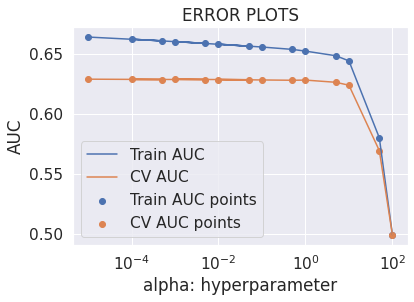

In [210]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math
train_auc = []
cv_auc = []
alpha =[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]


for i  in   tqdm(alpha):
    
    
    neigh = MultinomialNB(alpha=i)# takes the alpha from the i th list value
    neigh.fit(X_tr, y_train)# fit the model
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
    y_train_pred = neigh.predict_proba(X_tr)[:,1]#Return probability estimates for the set1x ,for the class label 1 or +ve.
    y_cv_pred = neigh.predict_proba(X_cr)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
# roc curve
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.xscale('log')# we take the log in the x axis
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.xscale('log')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [211]:

score_t_cv = [x for x in cv_auc]
opt_t_cv = alpha[score_t_cv.index(max(score_t_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_t_cv)))
print("Corresponding alpha value of cv is:",opt_t_cv, '\n')
best_alp=opt_t_cv
print(best_alp)

Maximum AUC score of cv is: 0.6288269438533163
Corresponding alpha value of cv is: 1e-05 

1e-05


## **Train model using the best hyper-parameter value of alpha**


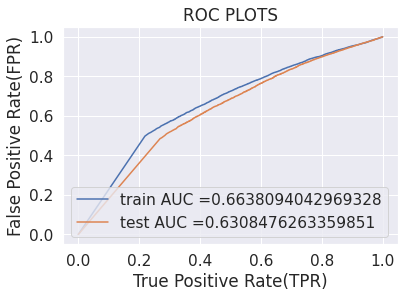

****************************************************************************************************


In [216]:
from sklearn.metrics import roc_curve, auc
neigh = MultinomialNB(alpha=1e-05)
neigh.fit(X_tr ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_te)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()
print("*"*100)

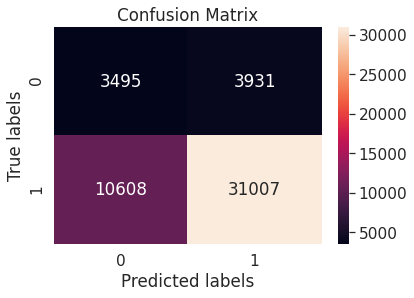

In [217]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_tr )), annot=True, ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

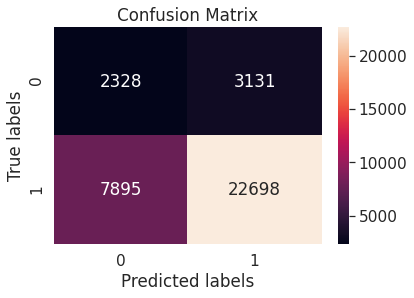

In [218]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_te )), annot=True, ax = ax,fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

# **Set 2 : categorical, numerical features + project_title(TFIDF) + preprocessed_essay (TFIDF)**


100%|██████████| 14/14 [00:02<00:00,  6.63it/s]


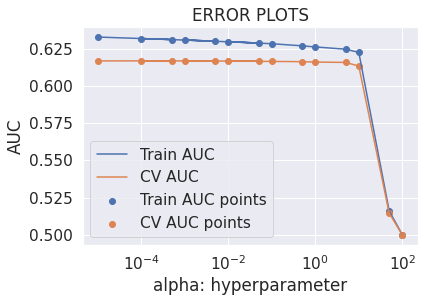

In [221]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math
train_aucr = []
cv_aucr = []
alpha =[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]


for i  in   tqdm(alpha):
    
    
    neigh = MultinomialNB(alpha=i)# takes the alpha from the i th list value
    neigh.fit(X_tr_set2, y_train)# fit the model
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
    y_train_pred = neigh.predict_proba(X_tr_set2)[:,1]#Return probability estimates for the set1x ,for the class label 1 or +ve.
    y_cv_pred = neigh.predict_proba(X_cr_set2)[:,1]#Return probability estimates for the setcvx,for the class label 1 or +ve .
# roc curve
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    train_aucr.append(roc_auc_score(y_train,y_train_pred))
    cv_aucr.append(roc_auc_score(y_cv, y_cv_pred))
plt.plot(alpha, train_aucr, label='Train AUC')
plt.plot(alpha, cv_aucr, label='CV AUC')
plt.xscale('log')# we take the log in the x axis
plt.scatter(alpha, train_aucr, label='Train AUC points')
plt.scatter(alpha, cv_aucr, label='CV AUC points')
plt.xscale('log')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [223]:
score = [x for x in cv_aucr]
opt = alpha[score.index(max(score))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score)))
print("Corresponding alpha value of cv is:",opt, '\n')
best_alpha=opt
print(best_alpha)

Maximum AUC score of cv is: 0.6169090360976947
Corresponding alpha value of cv is: 0.0005 

0.0005


## **Train model using the best hyper-parameter value of alpha**


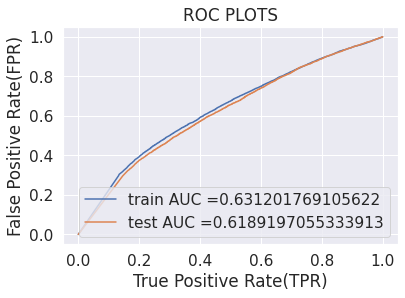

****************************************************************************************************


In [224]:
from sklearn.metrics import roc_curve, auc
neigh = MultinomialNB(alpha=0.0005)
neigh.fit(X_tr_set2 ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_tr_set2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_te_set2)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()
print("*"*100)

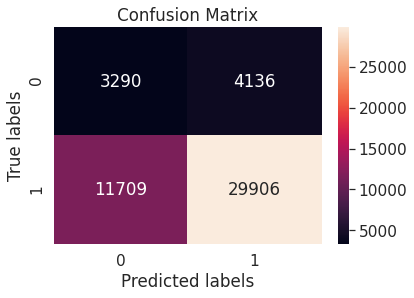

In [225]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_tr_set2 )), annot=True, ax = ax,fmt='g');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

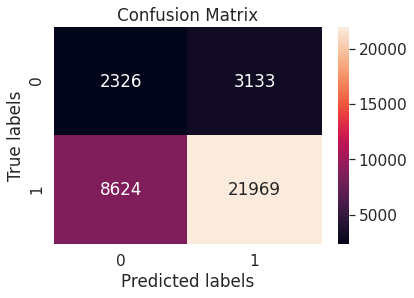

In [226]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_te_set2 )), annot=True, ax = ax,fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

# Top 20 features (negatives and positives)


### **for BOW**

In [252]:

nb_bow = MultinomialNB(alpha = 1e-05,class_prior=[0.5,0.5])

nb_bow.fit(X_tr, y_train)

bow_features_names1 = []

for a in vectorizer_proj.get_feature_names() :
    bow_features_names1.append(a)

for b in vectorizer_sub_proj.get_feature_names() :
    bow_features_names1.append(b)

for c in vectorizer_states.get_feature_names() :
    bow_features_names1.append(c)

for d in vectorizer_grade.get_feature_names() :
    bow_features_names1.append(d)

for e in vectorizer_teacher.get_feature_names() :
    bow_features_names1.append(e)

bow_features_names1.append("price")

bow_features_names1.append("quantity")


bow_features_names1.append("prev_proposed_projects")

bow_features_names1.append("title_word_count")

bow_features_names1.append("essay_word_count")

len(bow_features_names1)
for f in vectorizer_bow_title.get_feature_names() :
    bow_features_names1.append(f)
for g in vectorizer_bow_essay.get_feature_names() :
    bow_features_names1.append(g)

In [257]:
final_bow_features = pd.DataFrame({'feature_prob_estimates' : bow_features_probs, 'feature_names': bow_features_names1})
a =final_bow_features.sort_values(by = ['feature_prob_estimates'], ascending = False)
  # https://github.com/shashimanyam/NaiveBayes (hints have taken from here)
a.head(20)

,feature_prob_estimates,feature_names
100,-0.895607,price
104,-1.289947,essay_word_count
101,-3.772599,quantity
13268,-4.400951,to
2847,-4.557382,and
13113,-4.640449,the
102,-4.854687,prev_proposed_projects
12700,-4.867208,students
9644,-5.126496,of
103,-5.167163,title_word_count


In [259]:
bow_features_probs_pos = []
for a in range(14394):
    bow_features_probs_pos.append(nb.feature_log_prob_[1,a] )# negative feature probabilities
final_bow_features = pd.DataFrame({'feature_prob_estimates_pos' : bow_features_probs_pos,'feature_names' : bow_features_names1})
neg =final_bow_features.sort_values(by = ['feature_prob_estimates_pos'], ascending = False)
neg.head(20)

,feature_prob_estimates_pos,feature_names
100,-1.073479,price
104,-1.181888,essay_word_count
101,-3.922466,quantity
102,-4.259604,prev_proposed_projects
13268,-4.293541,to
2847,-4.458706,and
13113,-4.523625,the
12700,-4.743542,students
9644,-5.028639,of
103,-5.092388,title_word_count


# **Conclusion**

In [261]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Vectorizer", "Model", "HyperParameter", "AUC")
tb.add_row(["BOW", "Naive Bayes",1e-05, 63])
tb.add_row(["Tf-Idf", "Naive Bayes", 0.0005, 62])
print(tb.get_string(titles = "KNN - Observations"))

+------------+-------------+----------------+-----+
| Vectorizer |    Model    | HyperParameter | AUC |
+------------+-------------+----------------+-----+
|    BOW     | Naive Bayes |     1e-05      |  63 |
|   Tf-Idf   | Naive Bayes |     0.0005     |  62 |
+------------+-------------+----------------+-----+
